In [1]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
df_reg = pd.read_csv('data-p3/queuing-data-for-regression.csv')
df_reg

,cluster,avg_C0,avg_arrival_rate,est_service_rate,arrival_rate_per_server,service_rate_per_server
0,Weekday - 0:00 - 4:00,NaN,NaN,NaN,NaN,NaN
1,Weekday - 4:00 - 8:00,1.829927,0.730833,0.848,0.399378,0.463406
2,Weekday - 8:00 - 12:00,1.307122,1.063013,1.197,0.813247,0.915752
3,Weekday - 12:00 - 16:00,1.272101,1.052115,1.218,0.827069,0.957471
4,Weekday - 16:00 - 20:00,1.437122,1.090321,1.289,0.758684,0.896932
5,Weekday - 20:00 - 0:00,1.030120,0.074487,0.218,0.072309,0.211626
6,Weekend - 0:00 - 4:00,NaN,NaN,NaN,NaN,NaN
7,Weekend - 4:00 - 8:00,1.820351,0.711265,0.849,0.390730,0.466393
8,Weekend - 8:00 - 12:00,1.176645,0.886728,1.049,0.753608,0.891518
9,Weekend - 12:00 - 16:00,1.232898,1.076080,1.245,0.872805,1.009816


In [3]:
df_reg.dropna(inplace=True)

In [4]:
X = df_reg[['avg_arrival_rate']]
y = df_reg['est_service_rate']

In [5]:
model = LinearRegression()

model.fit(X,y)

LinearRegression()

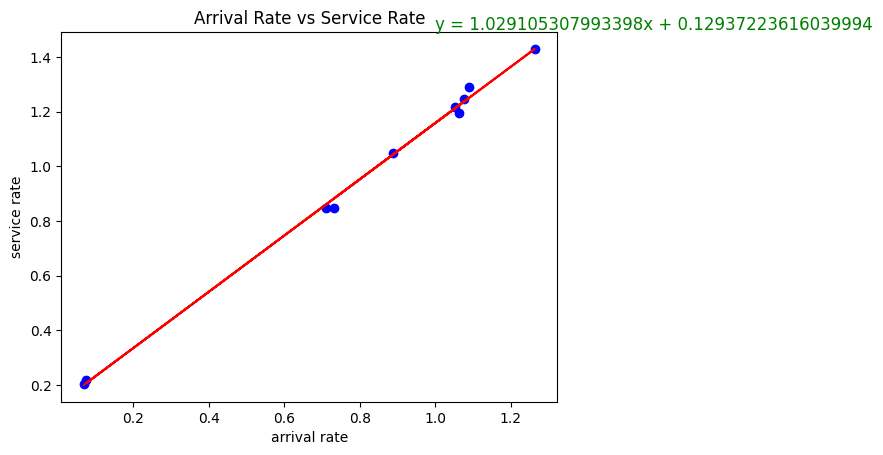

In [6]:
y_pred = model.predict(X)

slope = model.coef_[0]
intercept = model.intercept_

plt.scatter(X, y, color='blue', label='Actual Data')

# Plot the Regression Line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Add Labels and Legend
plt.xlabel('arrival rate')
plt.ylabel('service rate')
plt.title('Arrival Rate vs Service Rate')
equation = f"y = {slope}x + {intercept}"
plt.text(x=1, y=1.5, s=equation, fontsize=12, color='green')  # Adjust x, y coordinates as needed



# Show the Plot
plt.show()

In [7]:
df = pd.read_csv('data-p3/joined_all_clustered.csv')

In [8]:
thresholds = [5, 10, 15, 20, 25, 30]

cluster_metrics = df.groupby('cluster').apply(
    lambda group: pd.Series({
        'arrival_rate': len(group) / (group['cluster_hours'].mean() * 60),
        'avg_wait': group['wait_time_imp'].mean(),
        'avg_C0': group['C0 - S2'].mean()
    })
).reset_index()

cluster_metrics['est_service_rate'] = slope * cluster_metrics['avg_C0'] + intercept * cluster_metrics['arrival_rate']

cluster_metrics['traffic_intensity'] = cluster_metrics['arrival_rate'] / cluster_metrics['est_service_rate']

qos_results = []
for _, row in cluster_metrics.iterrows():
    cluster = row['cluster']
    arrival_rate = row['arrival_rate']
    avg_C0 = row['avg_C0']
    est_service_rate = slope * avg_C0 + intercept * arrival_rate
    
    qos_estimates = {}
    for x in thresholds:
        if arrival_rate < est_service_rate:  # Ensure λ < μ
            decay_factor = -(slope * avg_C0 + intercept * arrival_rate - arrival_rate) * x
            qos = 1 - (arrival_rate / est_service_rate) * np.exp(decay_factor)
            qos_estimates[f"<= {x} mins"] = f"{max(qos, 0):.1%}"
        else:
            qos_estimates[f"<= {x} mins"] = "N/A" 
    
    result = {
        "Cluster": cluster,
        "Est Serv Rate (per minute)": round(est_service_rate, 3),
        "Est ρ": round(arrival_rate / est_service_rate, 3),
        **qos_estimates
    }
    qos_results.append(result)

df_qos = pd.DataFrame(qos_results)
df_qos


/var/folders/8t/19klq0xd5w7cf39d3893ts0w0000gn/T/ipykernel_43387/3448033728.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = df.groupby('cluster').apply(


,Cluster,Est Serv Rate (per minute),Est ρ,<= 5 mins,<= 10 mins,<= 15 mins,<= 20 mins,<= 25 mins,<= 30 mins
0,Weekday - 12:00 - 16:00,1.445,0.728,89.8%,98.6%,99.8%,100.0%,100.0%,100.0%
1,Weekday - 16:00 - 20:00,1.620,0.673,95.2%,99.7%,100.0%,100.0%,100.0%,100.0%
2,Weekday - 20:00 - 0:00,1.070,0.070,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%
3,Weekday - 4:00 - 8:00,1.978,0.370,99.9%,100.0%,100.0%,100.0%,100.0%,100.0%
4,Weekday - 8:00 - 12:00,1.483,0.717,91.2%,98.9%,99.9%,100.0%,100.0%,100.0%
5,Weekend - 12:00 - 16:00,1.408,0.764,85.5%,97.2%,99.5%,99.9%,100.0%,100.0%
6,Weekend - 16:00 - 20:00,1.739,0.727,93.3%,99.4%,99.9%,100.0%,100.0%,100.0%
7,Weekend - 20:00 - 0:00,1.038,0.066,99.9%,100.0%,100.0%,100.0%,100.0%,100.0%
8,Weekend - 4:00 - 8:00,1.965,0.362,99.9%,100.0%,100.0%,100.0%,100.0%,100.0%
9,Weekend - 8:00 - 12:00,1.326,0.669,92.5%,99.2%,99.9%,100.0%,100.0%,100.0%
